In [ ]:
# 1. Import Libraries


# System Libraries
import os
import time
import shutil
import pathlib
import itertools
import zipfile

# Data Handling Libraries
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Display that modules are loaded
print('Modules loaded')

Modules loaded


In [ ]:

# 2. Set Up Kaggle Dataset

# Setup Kaggle credentials for accessing the dataset
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Download the dataset from Kaggle
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Extract the dataset from the zip file
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest-xray-pneumonia')
print('Dataset extracted successfully!')

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:20<00:00, 217MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s]
Dataset extracted successfully!


In [ ]:
# 3. Data Preprocessing


# Define paths and labels for the dataset
data_dir = '/content/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

# Iterate over the dataset folders and collect file paths and labels
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create a DataFrame containing filepaths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Split the dataset into train, validation, and test sets
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)


In [ ]:
# 4. Image Data Generators


# Image preprocessing parameters
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Function for scaling images
def scalar(img):
    return img

# Data generators for training, validation, and testing
tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size)

# For test set, use custom batch size and disable shuffling
test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=16)


Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


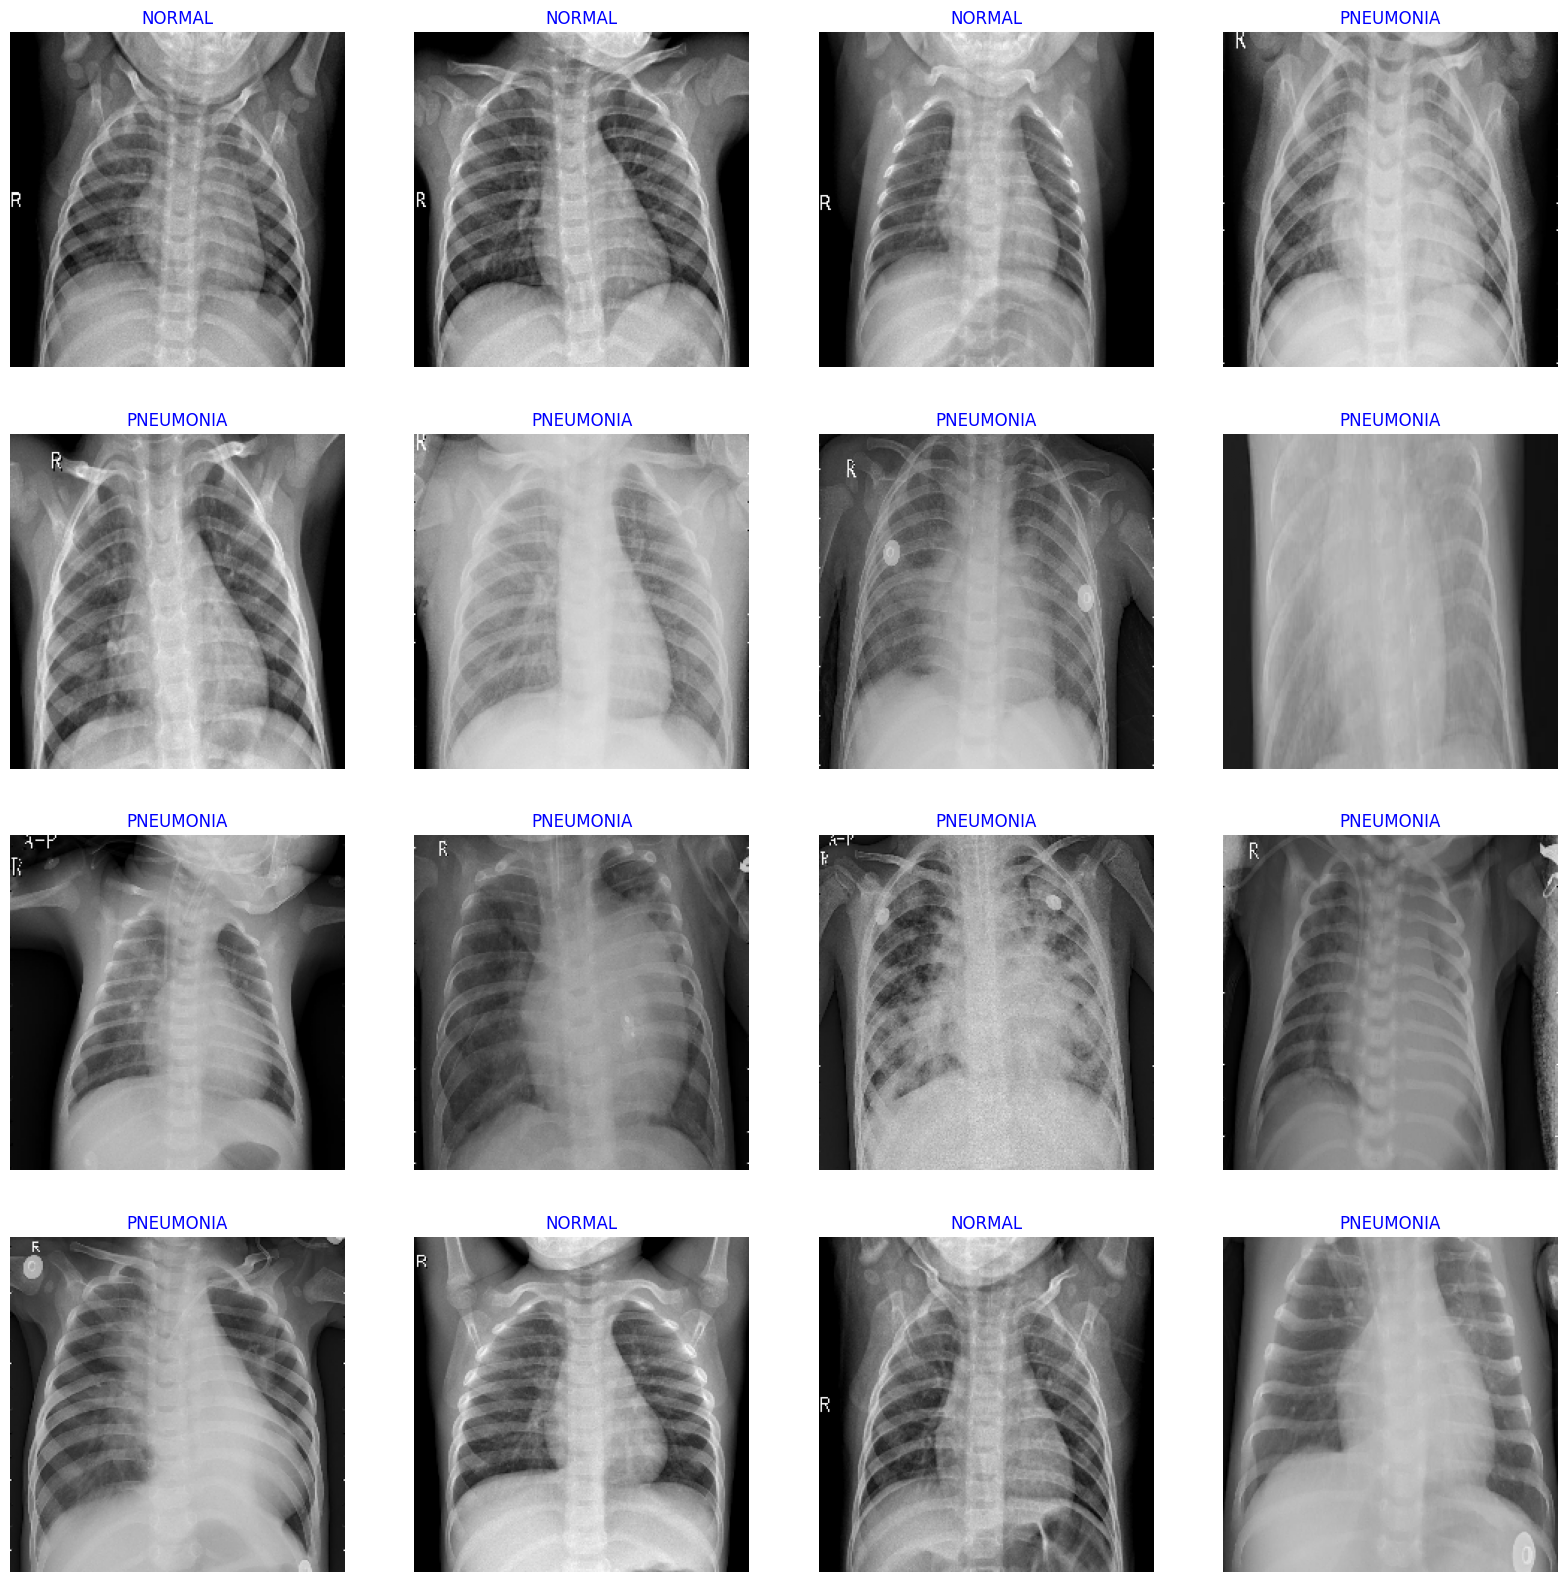

In [ ]:
# 5. Visualize a Batch of Images


# Visualize a batch of images from the training set
g_dict = train_gen.class_indices  # Dictionary of class names and indices
classes = list(g_dict.keys())     # List of class names

images, labels = next(train_gen)  # Get a batch of images
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # Normalize image data
    plt.imshow(image)
    index = np.argmax(labels[i])  # Get class index for image
    class_name = classes[index]  # Get class name
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

In [ ]:
# 6. Model Creation


# Define the base model (EfficientNetB0 pre-trained on ImageNet)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 4,338,558 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
# 7. Training the Model


# Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=20, class_weight={0: 1., 1: 10.})


Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 178s 386ms/step - accuracy: 0.8392 - loss: 14.9638 - val_accuracy: 0.7652 - val_loss: 8.1552
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 108s 199ms/step - accuracy: 0.8200 - loss: 7.4256 - val_accuracy: 0.7923 - val_loss: 6.5851
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 88s 221ms/step - accuracy: 0.8240 - loss: 6.3166 - val_accuracy: 0.9073 - val_loss: 5.3955
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 62s 233ms/step - accuracy: 0.7712 - loss: 5.4126 - val_accuracy: 0.8578 - val_loss: 4.5786
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 59s 221ms/step - accuracy: 0.7486 - loss: 4.5786 - val_accuracy: 0.8786 - val_loss: 4.1329
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 221ms/step - accuracy: 0.7638 - loss: 3.8053 - val_accuracy: 0.8355 - val_loss: 3.1028
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.8076 - loss: 3.1308 - val_accuracy: 0.8275 - val_loss: 2.6308
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 201ms/step - accuracy: 0.8142 - loss

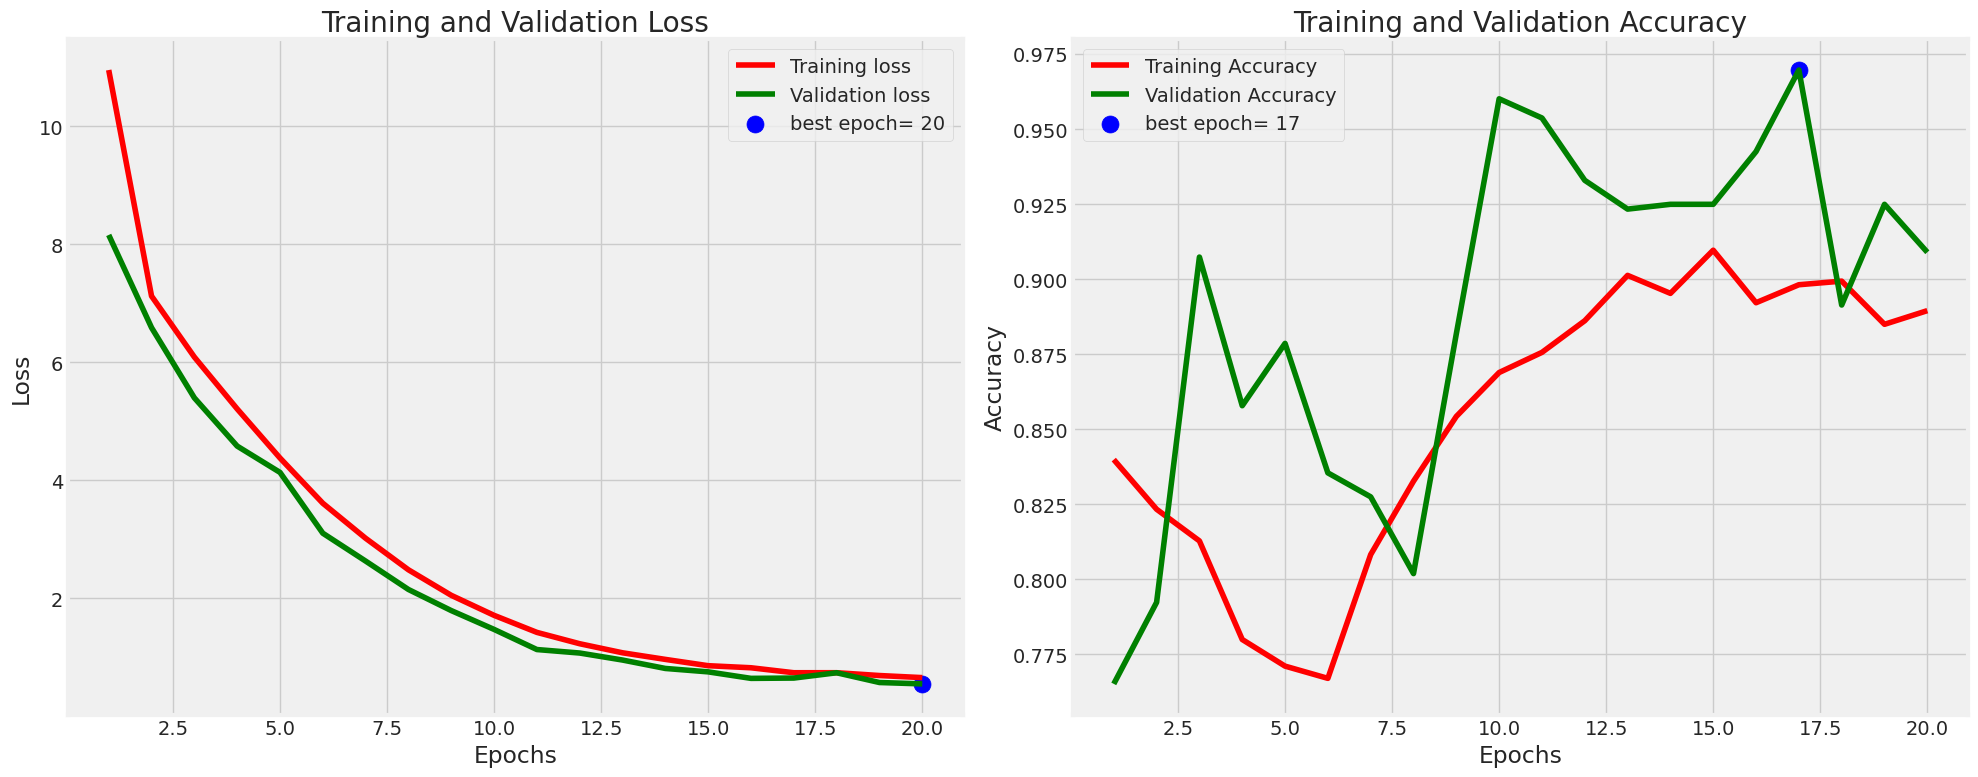

In [ ]:
# 8. Plot Training History


# Plot training and validation loss and accuracy
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(np.argmin(val_loss) + 1)}'
acc_label = f'best epoch= {str(np.argmax(val_acc) + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(np.argmin(val_loss) + 1, val_loss[np.argmin(val_loss)], s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(np.argmax(val_acc) + 1, val_acc[np.argmax(val_acc)], s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 9. Evaluate the Model


# Evaluate the model on the train, validation, and test sets
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.9079 - loss: 0.5486
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9220 - loss: 0.5434
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9219 - loss: 0.5319
Train Loss:  0.5444000959396362
Train Accuracy:  0.9125120043754578
--------------------
Validation Loss:  0.5502331256866455
Validation Accuracy:  0.9089456796646118
--------------------
Test Loss:  0.5613167881965637
Test Accuracy:  0.89952152967453


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step


Text(25.347222222222214, 0.5, 'True Label')

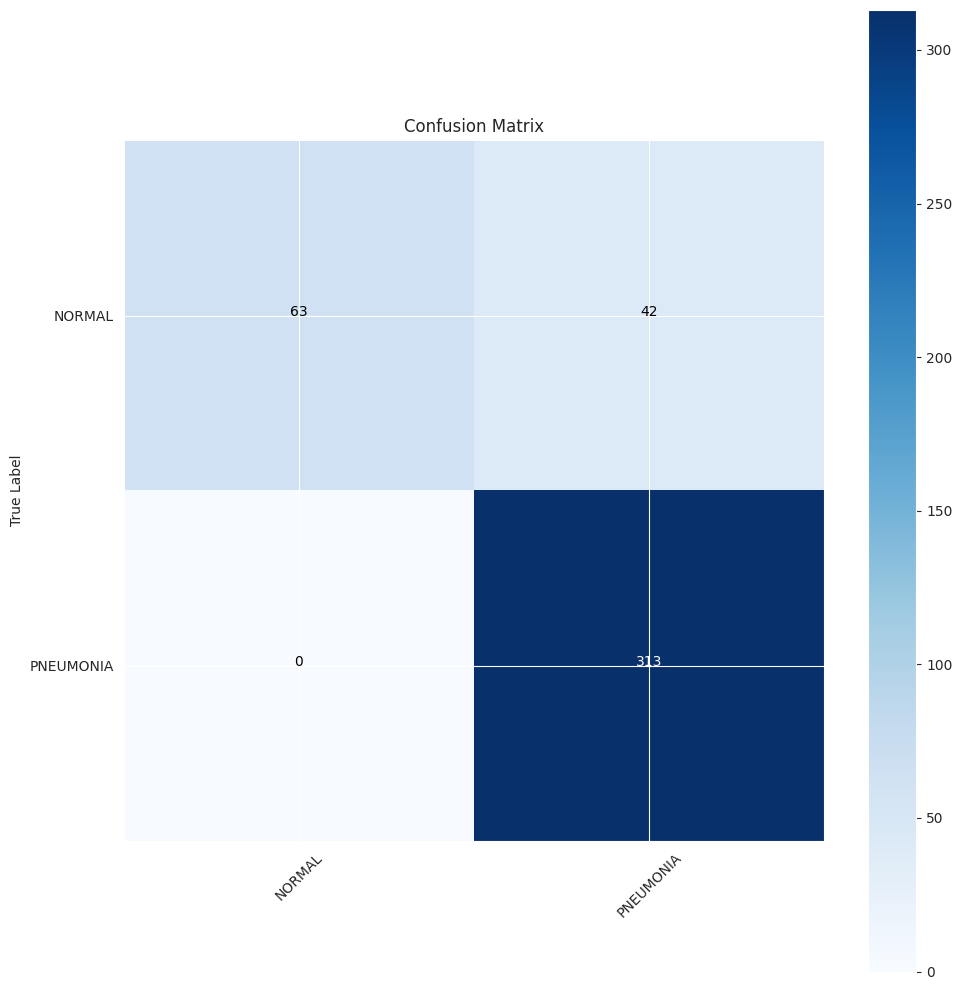

In [ ]:
# 10. Confusion Matrix & Classification Report


# Predict on the test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [ ]:
# 11. Save the Model and Weights


# Save the trained model
model_name = model.layers[0].name[:-6]
subject = 'Indian Rock Python'
acc = test_score[1] * 100
save_path = '/content/'

save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Save model weights
weight_save_id = f'{model_name}-{subject}.weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')


Model was saved as /content/efficien-Indian Rock Python-89.95.h5
Weights were saved as /content/efficien-Indian Rock Python.weights.h5


In [ ]:
# 12. Save the Class Dictionary


class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)
width = [img_size[1]] * len(class_dict)

# Create dataframe for class info
Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

# Save to CSV
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'Class dictionary CSV was saved as {csv_save_loc}')

Class dictionary CSV was saved as /content/Indian Rock Python-class_dict.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


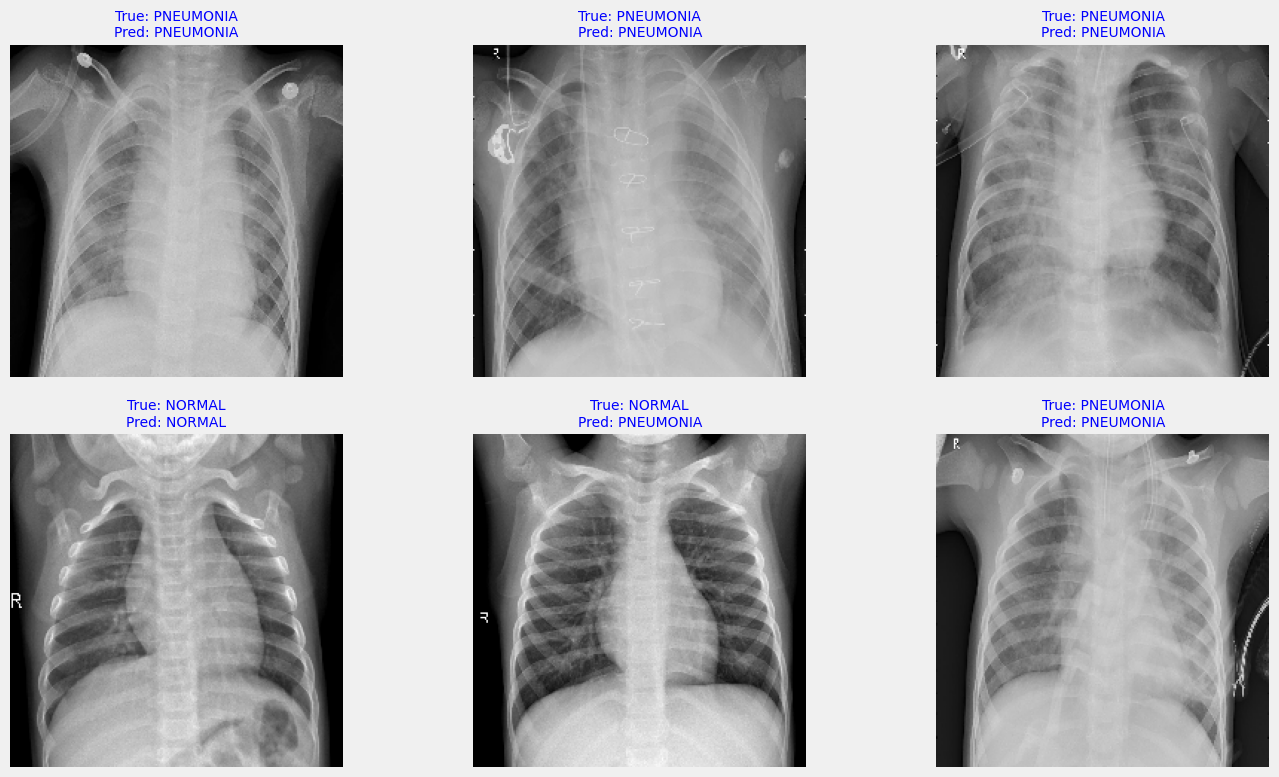

In [ ]:
# 13. Visualize Predictions (Post Fine-Tuning)


plt.figure(figsize=(15, 8))

# Sample predictions from the test set
images, labels = next(test_gen)  # Get a batch from the test generator
predictions = model.predict(images)  # Predict the images in the batch

# Display first 6 predictions in a 2x3 grid
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image = images[i] / 255.0  # Normalize the image to 0-1
    plt.imshow(image)
    true_label = np.argmax(labels[i])  # True label index
    predicted_label = np.argmax(predictions[i])  # Predicted label index
    true_class = classes[true_label]  # True class name
    predicted_class = classes[predicted_label]  # Predicted class name

    # Set title to show both true and predicted labels
    plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=10, color="blue")

    # Hide axes for better presentation
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 15. Evaluate the Model After Fine-Tuning

# Calculate test_steps based on the size of the test set and desired batch size
# Assuming test_gen is a data generator and batch_size is the desired batch size
import math

batch_size = 32 # Replace with your actual batch size
test_steps = math.ceil(len(test_gen.filepaths) / batch_size) # Get total number of steps

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9019 - loss: 0.5561
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9246 - loss: 0.5259
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9364 - loss: 0.5144
Train Loss:  0.54865962266922
Train Accuracy:  0.9241071343421936
--------------------
Validation Loss:  0.5602086186408997
Validation Accuracy:  0.9107142686843872
--------------------
Test Loss:  0.526043176651001
Test Accuracy:  0.9241071343421936


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step


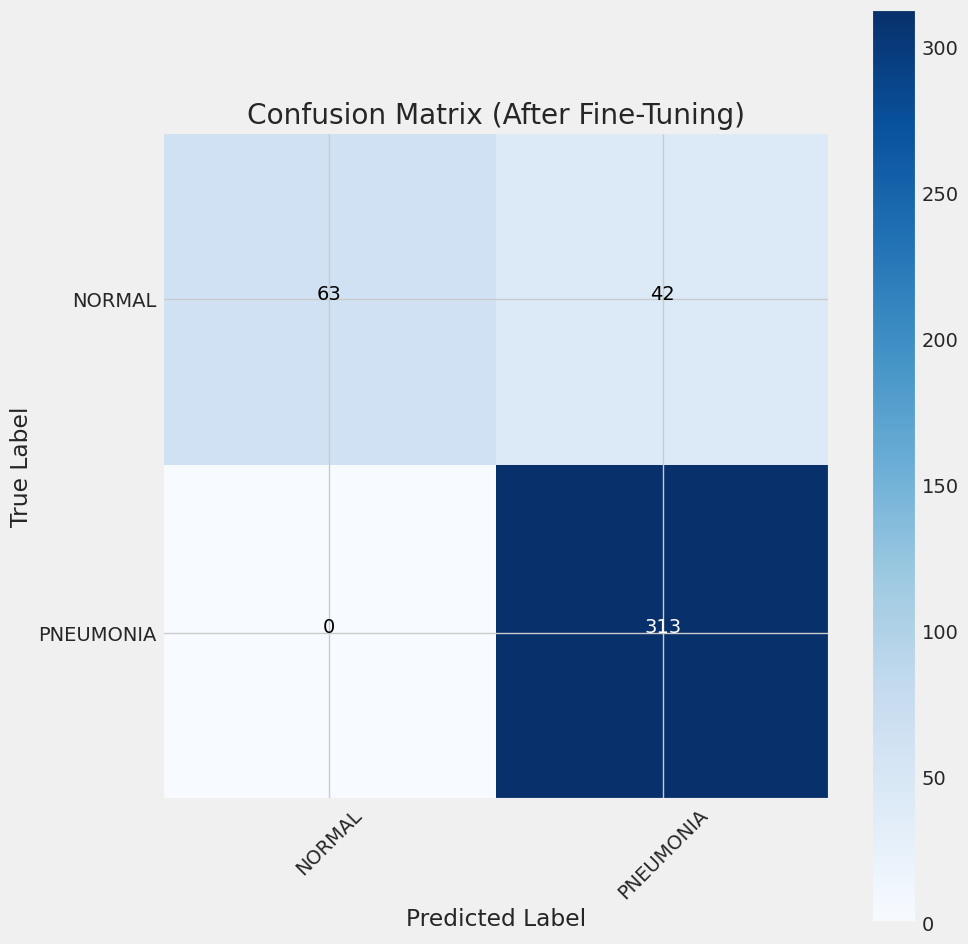

              precision    recall  f1-score   support

      NORMAL       1.00      0.60      0.75       105
   PNEUMONIA       0.88      1.00      0.94       313

    accuracy                           0.90       418
   macro avg       0.94      0.80      0.84       418
weighted avg       0.91      0.90      0.89       418



In [ ]:
# 16. Final Confusion Matrix & Classification Report After Fine-Tuning


# Predict on the test set after fine-tuning
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (After Fine-Tuning)')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))